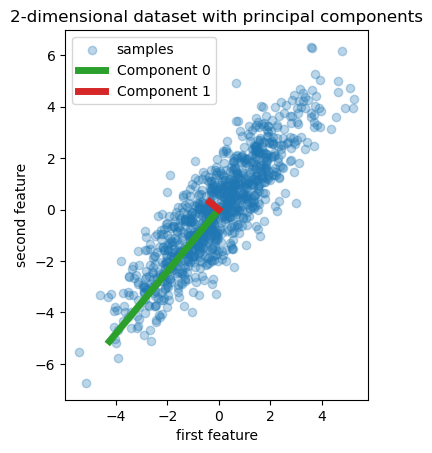

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

rng = np.random.RandomState(1)
n_samples = 1000
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')
for i, (comp,var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

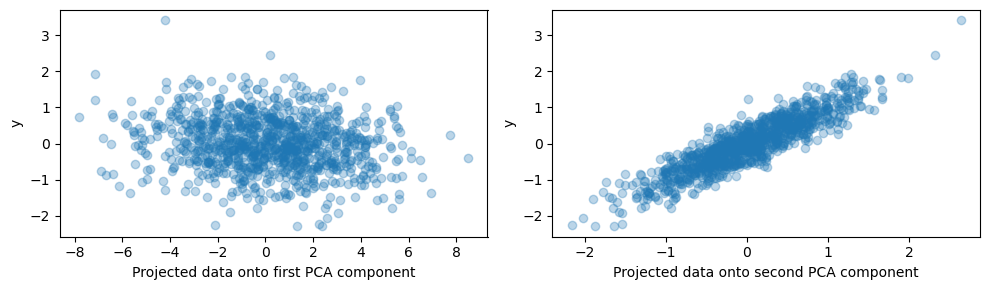

In [3]:
y = X.dot(pca.components_[1] + 0.1 * rng.randn(2)) + 0.3 * rng.randn(n_samples)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(X.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel="Projected data onto first PCA component",
            ylabel='y')
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel="Projected data onto second PCA component",
            ylabel='y')
fig.tight_layout()
plt.show()

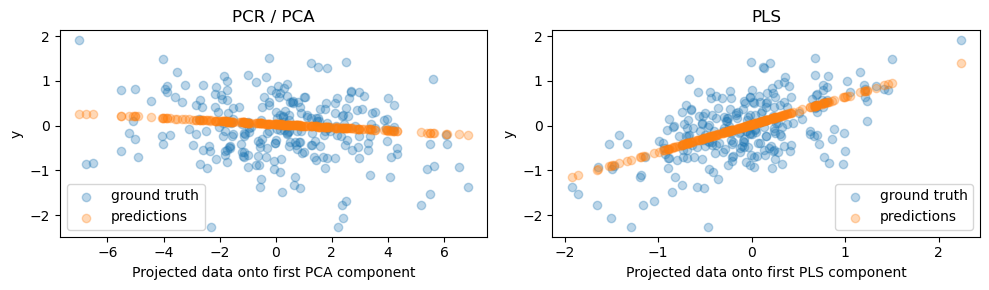

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

pca = pcr.named_steps['pca']  

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test)[:, 0], pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test)[:, 0], pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
fig.tight_layout()
plt.show()

In [13]:
import cvxpy as cp
    
class PLS1():
    def __init__(self, n_components) -> None:
        self.n_components = n_components
    
    def _fit_cvxpy(self,X,y):
        n_samples, n_features = X.shape
        W = cp.Variable((n_features,self.n_components))
        C = cp.Variable((1,self.n_components))
        objective = cp.Minimize(cp.norm(y - X@W@C.T))
        constraints = [cp.norm(W[:,i]) == 1 for i in range(self.n_components)]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        self.W = W.value
        self.C = C.value

    def _fit_scipy(self,X,y):
        n_samples, n_features = X.shape
        def Cov(X,y):
            return X.T @ y / n_samples
        from scipy.optimize import minimize
        def objective(W):
            return np.linalg.norm(y - X@W@C.T)
        def constraint(W):
            return np.linalg.norm(W[:,i]) - 1
        
        

        self.W = W
        self.C = C
        return self.W,self.C

    def fit(self,X,y, package= None):
        assert X.shape[0] > self.n_components, "n_components must be smaller than the number of samples"
        if package == 'scipy':
            self._fit_scipy(X,y)
        elif package == 'cvxpy':
            self._fit_cvxpy(X,y)
        else:
            print("Solve from scratch")
            n_samples, n_features = X.shape
            def Cov(X,y):
                return X.T @ y / n_samples
            W = np.random.randn(n_features,self.n_components)
            C = np.random.randn(1,self.n_components)
            for i in range(self.n_components):
                Covariance = Cov(X@W[:,i].reshape(-1,1),y)
                W[:,i] = Covariance / np.linalg.norm(Covariance)
                C[:,i] = Cov(X@W[:,i].reshape(-1,1),y)
                X = X - X@W[:,i].reshape(-1,1) @ C[:,i].reshape(1,-1)
            self.W = W
            self.C = C
            return self.W,self.C
        
    def predict(self,X):
        X_scaled = (X - self.X_mean) / self.X_std
        y_pred = X_scaled @ self.W @ self.C.T * self.y_std + self.y_mean
        return y_pred
    
    def transform(self,X):
        X_scaled = (X - self.X_mean) / self.X_std
        T = X_scaled @ self.W
        return T
    
    def fit_transform(self,X,y):
        self.fit(X,y)
        T = self.transform(X)
        return T
    
    def score(self,X,y):
        y_pred = self.predict(X)
        score = np.mean((y - y_pred)**2)
        return score
    
    def get_params(self,deep=True):
        return {'n_components':self.n_components}
    

In [14]:
pls1 = PLS1(n_components=0)
W,C = pls1.fit(X_train,y_train.reshape(-1,1))

Solve from scratch


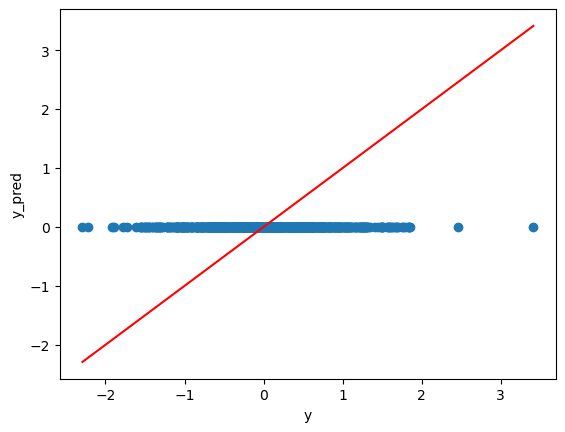

In [12]:
def plot_regression(X,y,W,C):
    y_pred = X @ W @ C.T
    plt.scatter(y,y_pred)
    plt.plot([y.min(),y.max()],[y.min(),y.max()],color='red')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.show()

plot_regression(X_train,y_train,W,C)

In [4]:
import numpy as np
import cvxpy as cp

def pls1(X, y, n_components):
    # Số lượng mẫu và biến
    n_samples, n_features = X.shape
    
    # Tạo các biến của bài toán tối ưu
    w = cp.Variable((n_features, 1))
    t = cp.Variable((n_samples, 1))
    
    # Hàm mục tiêu
    objective = cp.Maximize(cp.sum((X @ w).T * y))
    
    # Ràng buộc
    constraints = [cp.norm(w, 2) == 1, t == X @ w]
    
    # Tạo bài toán tối ưu
    prob = cp.Problem(objective, constraints)
    
    # Giải bài toán
    prob.solve()
    
    # Trích xuất vector hệ số w tối ưu
    w_optimal = w.value
    
    return w_optimal

# Example usage:
# X là ma trận biến độc lập, y là vector biến phụ thuộc
# n_components là số lượng thành phần chính cần tìm
X = np.random.rand(100, 5)  # Ví dụ: 100 mẫu, 5 biến
y = np.random.rand(100, 1)  # Ví dụ: 100 mẫu, 1 biến phụ thuộc
print(X.shape, y.shape)
n_components = 2  # Số lượng thành phần chính

w_optimal = pls1(X, y, n_components)
print("Vector hệ số w tối ưu:", w_optimal)


(100, 5) (100, 1)


/home/golde/anaconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
Pnorm(reshape(var26, (5,), F), 2) == 1.0 , because the following subexpressions are not:
|--  Pnorm(reshape(var26, (5,), F), 2) == 1.0